In [9]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import matplotlib.pyplot as plt

EPOCH = 10
BATCH_SIZE = 50
LR = 0.001  # 学习率
DOWNLOAD_MNIST = False  # 不下载
ROOT = '/root/private/torch_datasets/'

train_data = torchvision.datasets.MNIST(
    root=ROOT,  # 数据集文件
    train=True,  # 训练集数据
    transform=torchvision.transforms.ToTensor(),  # 变成tensor，做归一化处理
    download=DOWNLOAD_MNIST
)

test_data = torchvision.datasets.MNIST(
    root=ROOT,
    train=False,  # 训练集数据
    download=DOWNLOAD_MNIST
)

train_loader = data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
    #num_workers=8,
)

train_data.data.shape, train_data.targets.shape, \
test_data.data.shape, test_data.targets.shape


(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [13]:
# 由于test_data没有用transform，所以要手动转换成张量，并进行归一化
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor) / 255.
test_y = test_data.targets
test_x.shape, test_y.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

torch.Size([28, 28])
tensor(5)


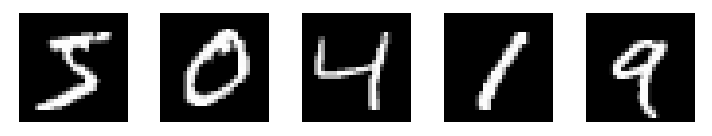

In [3]:
arr = train_data.data[0:5]
print(arr[0].shape)
print(train_data.targets[0])


def show(image_arr):
    fig, axes = plt.subplots(1, len(image_arr), figsize=(10, 2))
    axes = axes.flatten()
    for image, ax in zip(image_arr, axes):
        ax.imshow(image, plt.cm.gray)
        ax.axis('equal')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


show(arr)


In [7]:
class MyLinear(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyLinear, self).__init__()
        self.hidden = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_input, n_hidden),
            nn.Sigmoid(),
        )
        self.output = nn.Sequential(
            nn.Linear(n_hidden, n_output),
            nn.Sigmoid(),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x


# 模型，打印看模型
my_linear = MyLinear(28 * 28, 25, 10)
print(my_linear)

# 优化器接收参数
optimizer = torch.optim.Adam(my_linear.parameters(), lr=LR)  

# 损失函数。
# target label is not one-hotted
loss_fun = nn.CrossEntropyLoss()  




MyLinear(
  (hidden): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=25, bias=True)
    (2): Sigmoid()
  )
  (output): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Softmax(dim=1)
  )
)


In [8]:
EPOCH = 2

for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        output = my_linear(b_x)  # cal output
        loss = loss_fun(output, b_y)  # cal loss
        optimizer.zero_grad()  # clear grad for this training
        loss.backward()  # backpropagation, cal grad
        optimizer.step()

    test_output = my_linear(test_x)
    pred_y = torch.max(test_output, 1)[1].data.numpy()
    # torch.max 对test_output的dim=1取最大值，也就是每个输入的输出
    # max返回两个值(max_val, max_index)，[1]就是取index
    acc = (pred_y == test_y.data.numpy()).astype(int).sum() / \
          float(test_y.size()[0])
    outformat = 'EPOCH: {:d} | Loss: {:.2f} | Accuracy: {:%}'
    print(outformat.format(epoch, loss.data.numpy(), acc))
   

EPOCH: 0 | Loss: 2.21 | Accuracy: 89.370000%


EPOCH: 1 | Loss: 2.20 | Accuracy: 91.190000%


In [10]:
torch.save(my_linear, './test_torch/MyLinearModelOfMNIST.pkl')
torch.save(my_linear.state_dict(), './test_torch/MyLinearModelParamOfMNIST.pkl')

Label: 9 | Predict: 9


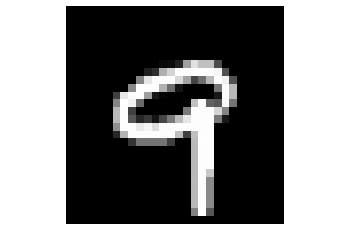

In [74]:
import torch
import matplotlib.pyplot as plt


def show(image, label, pred):
    print('Label: {:d} | Predict: {:d}'.format(label, pred))
    fig, ax = plt.subplots()
    ax.imshow(image, plt.cm.gray)
    ax.axis('equal')
    ax.axis('off')
    plt.show()


INDEX = 9376
loaded_linear = torch.load('./test_torch/MyLinearModelOfMNIST.pkl')
output = loaded_linear(test_x[INDEX])
pred = torch.max(output, 1)[1].data.numpy()[0]

show(
    image=test_x.data.numpy()[INDEX][0],
    label=test_y.data.numpy()[INDEX],
    pred=pred
)
# test_y[INDEX].data.numpy()
# test_x.data.numpy()[INDEX][0].shape
# test_y.data.numpy()[0]